# Retention Insert Scores Fallback
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 7, 2022

In [1]:
import boto3
import getpass
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import awswrangler as wr
import warnings

from datetime import datetime
from pytz import timezone
from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [4]:
lkupclientid = 93
dbname = 'stlrnhlpanthers'

cursor = CNXN.cursor()

storedProc = (
    f"""Exec {dbname}.[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

print(f"TOTAL ROWS: {df.shape[0]}")
df.head()

TOTAL ROWS: 16427


,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,tenure,distToVenue,totalGames,recency,missed_games_1,missed_games_2,missed_games_over_2,click_link,fill_out_form,open_email,send_email,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,posting_records,resale_records,resale_atp,forward_records,cancel_records,email,inbound_email,inbound_phonecall,inperson_contact,internal_note,left_message,outbound_email,outbound_phonecall,phonecall,text,unknown,gender,childrenPresentInHH,maritalStatus,lengthOfResidenceInYrs,annualHHIncome,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer
0,93,1833667,17139510,2017,Flex Plan,198.0,2018-03-24,1.000000,29,TRUE,1825,93,354.167202,3,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,43,None,0
1,93,1834257,15915892,2017,Half Season,2184.0,2018-04-05,0.952381,-13,TRUE,2555,178,354.167202,20,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,43,None,1
2,93,1839513,15196725,2017,Full Season,9048.0,2018-04-05,0.519737,9,TRUE,2920,178,354.167202,26,0,2,3,4,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,43,None,1
3,93,1840803,3167965,2017,Half Season,3024.0,2018-04-05,0.904762,-13,TRUE,9125,178,354.167202,19,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,43,None,0
4,93,1843847,3746214,2017,Full Season,33432.0,2018-04-07,1.012195,-84,TRUE,6205,109,354.167202,42,0,2,0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,,1,1,None,None,None,None,0.0,0,43,None,1


### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "lkupClientId",
    "productGrouping",
    "recency",
    "recentDate",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8965, 11)
Unseen Data For Predictions: (1582, 11)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimCustomerMasterId",
        "lkupClientId",
        "productGrouping",
        "recentDate",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [7]:
model_matrix = compare_models(
    fold= 10,
    include= ["xgboost"],
    probability_threshold= 0.75
)

final_model = finalize_model(model_matrix)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6257,0.7582,0.4773,0.8060,0.5993,0.2892,0.3247,0.6140


### Let's load in our 2021 season data and get retention scores using the model:

In [8]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(3694, 11)

In [9]:
df_predictions = (predict_model(final_model, data=df_inference, raw_score=True))
df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]

### We can create some histograms to visualize each model distribution:

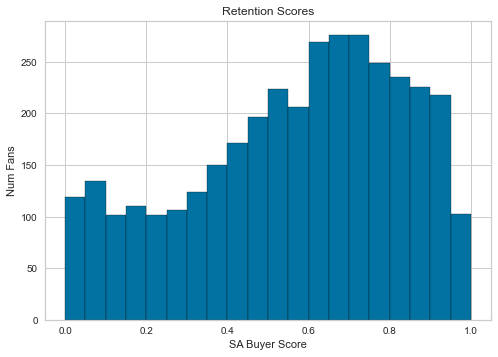

In [10]:
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.hist(df_predictions["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.show()

### We can also see how many purchases there are in each range of scores:

In [11]:
df_predictions["Score_1"].value_counts(bins=np.arange(0, 1.05, 0.05)).sort_index(ascending=False)

(0.95, 1.0]       102
(0.9, 0.95]       219
(0.85, 0.9]       226
(0.8, 0.85]       235
(0.75, 0.8]       248
(0.7, 0.75]       277
(0.65, 0.7]       274
(0.6, 0.65]       271
(0.55, 0.6]       206
(0.5, 0.55]       224
(0.45, 0.5]       197
(0.4, 0.45]       171
(0.35, 0.4]       150
(0.3, 0.35]       124
(0.25, 0.3]       106
(0.2, 0.25]       102
(0.15, 0.2]       110
(0.1, 0.15]       102
(0.05, 0.1]       135
(-0.001, 0.05]    119
Name: Score_1, dtype: int64

### First we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [12]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

HGWF-WCBT
Successully logged into Start URL: https://stellaralgo.awsapps.com/start


### Now we can create a session and client to RedShift, and create a new connection using AWS wrangler:

In [13]:
session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')
client = boto3.client('redshift')
    
conn = wr.data_api.redshift.connect(
    cluster_id = "qa-app",
    database = dbname,
    db_user = "admin"
)

print("CREDENTIALS RETRIEVED SUCCESSFULLY!")

CREDENTIALS RETRIEVED SUCCESSFULLY!


### Before we insert new scores, let's grab a list of the most recent scores (currVersnFlag=1) so we can update them after the new scores are pushed:

In [14]:
sql_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE currversnflag = 1
"""
    
df_recent_scores = wr.data_api.redshift.read_sql_query(
    sql = sql_statement, 
    con = conn
)

print(f"TOTAL RECORDS: {df_recent_scores.shape[0]}")

TOTAL RECORDS: 0


### Insert the new scores into the customerretentionscores table in batches:

In [16]:
batch_size = 250
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {dbname} ({lkupclientid})")

fields = f"""
INSERT INTO {dbname}.dw.customerretentionscores (
    attendancePercentage,
    currversnflag,
    dimcustomermasterid,
    insertdate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonYear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        values = f"""
            (
                {str(row.attendancePercent)},
                {str(1)},
                {str(row.dimCustomerMasterId)},
                '{str(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))}',
                {str(lkupclientid)},
                '{str(row.recentDate)}',
                '{str(row.productGrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    wr.data_api.redshift.read_sql_query(
        sql = insert_statement, 
        con = conn
    )
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 3598 NEW RETENTION SCORES TO DATABASE: stlrnhlpanthers (93)
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 1 : ROWS 1 - 250
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 2 : ROWS 251 - 500
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 3 : ROWS 501 - 750
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 4 : ROWS 751 - 1000
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 5 : ROWS 1001 - 1250
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 6 : ROWS 1251 - 1500
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 7 : ROWS 1501 - 1750
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 8 : ROWS 1751 - 2000
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 9 : ROWS 2001 - 2250
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 10 : ROWS 2251 - 2500
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 11 : ROWS 2501 - 2750
Empty DataFrame
Columns: []
Index: []
 > INSERTED BATCH 12 : ROWS 2751 - 3000
Empty DataFr

### Now let's update the old scores to currVersFlag = 0

In [ ]:
print(f"UPDATING {len(df_recent_scores)} OLD RETENTION SCORES IN DATABASE:")

ids = ', '.join(map(str, list(df_recent_scores['customerretentionscoreid'])))

update_statement = f"""
    UPDATE {dbname}.dw.customerretentionscores
    SET currversnflag = 0 
    WHERE customerretentionscoreid IN ({ids})
"""

wr.data_api.redshift.read_sql_query(
    sql = update_statement, 
    con = conn
)

print(f"UPDATED {len(df_recent_scores)} SUCCESSFULLY")

### Let's query RedShift to make sure our records got into the database:

In [110]:
select_statement = f"""
    SELECT *
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

df_scores = wr.data_api.redshift.read_sql_query(
    sql = select_statement, 
    con = conn
)

df_current_scores = df_scores[df_scores['currversnflag'] == 'true']

print(f"TOTAL RECORDS: {df_current_scores.shape[0]}")
df_scores['currversnflag'].value_counts()

TOTAL RECORDS: 4504


false    9008
true     4504
Name: currversnflag, dtype: int64

### We can also use the API to delete records from the database:

In [ ]:
delete_statement = f"""
    DELETE 
    FROM {dbname}.dw.customerretentionscores
    WHERE lkupclientid = {lkupclientid}
"""

wr.data_api.redshift.read_sql_query(
    sql = delete_statement, 
    con = conn
)

print(f"DELETED ALL RECORDS SUCCESSFULLY FROM: {dbname} ({lkupclientid})")